In [6]:
import pandas as pd
df = pd.read_csv("../dataset/reddit.csv")
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB
None
       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2                 0      3  
3 

In [11]:
import re

def clean_text(text):
    text = str(text).lower()                       # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)    # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s#]", "", text)  # remove punctuation, keep hashtags
    text = re.sub(r"\s+", " ", text).strip()     # remove extra spaces
    return text

df_combined['clean_text'] = df_combined['text'].apply(clean_text)



In [13]:
print(df.head())

       subreddit                                               body  \
0  gameofthrones  Your submission has been automatically removed...   
1            aww  Dont squeeze her with you massive hand, you me...   
2         gaming  It's pretty well known and it was a paid produ...   
3           news  You know we have laws against that currently c...   
4       politics  Yes, there is a difference between gentle supp...   

   controversiality  score  
0                 0      1  
1                 0     19  
2                 0      3  
3                 0     10  
4                 0      1  


In [5]:
import pandas as pd
import re


df_reddit = pd.read_csv("../dataset/reddit.csv")
df_reddit['source'] = 'reddit'


df_reddit = df_reddit[['body', 'source']]
df_reddit.rename(columns={'body': 'text'}, inplace=True)


df_insta = pd.read_csv("../dataset/insta.csv")
df_insta['source'] = 'instagram'
df_insta = df_insta[['Caption', 'source']]
df_insta.rename(columns={'Caption': 'text'}, inplace=True)


df_combined = pd.concat([df_reddit, df_insta], ignore_index=True)


def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s#]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_combined['clean_text'] = df_combined['text'].apply(clean_text)


In [6]:

df_combined['source'].value_counts()
# Show 5 random Instagram rows
df_combined[df_combined['source']=='instagram'].sample(5, random_state=42)


,text,source,clean_text
1005023,🔫🔫,instagram,
1009624,Loved working with on this cover shoot!,instagram,loved working with on this cover shoot
1004802,Happy St. Patricks day 💚🍀,instagram,happy st patricks day
1009418,🎵🎶 Remember who you are...No you're not perfec...,instagram,remember who you areno youre not perfect but y...
1007639,Calabasas girl in Turks,instagram,calabasas girl in turks


In [7]:
# Sample Reddit to 50k rows because reddit set is too long
reddit_sample = df_combined[df_combined['source']=='reddit'].sample(50000, random_state=42)
instagram_sample = df_combined[df_combined['source']=='instagram']  # all 17k

# Combine into one balanced DataFrame
df_sample = pd.concat([reddit_sample, instagram_sample], ignore_index=True)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_sample['clean_text'])
print(X.shape)



(67100, 1000)


In [26]:
from sklearn.cluster import KMeans

num_clusters = 5  # You can adjust based on how many trends you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X)


In [27]:
feature_names = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"\nCluster {i}:")


    sample_texts = df_sample[df_sample['cluster']==i]['clean_text'].sample(5, random_state=42).tolist()
    for text in sample_texts:
        print("-", text)


    cluster_indices = df_sample[df_sample['cluster']==i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)
    top_word_indices = cluster_vector_sum.argsort()[0, -10:][0][::-1]
    top_words = [feature_names[idx] for idx in top_word_indices]
    print("Top words:", top_words)


    source_counts = df_sample[df_sample['cluster']==i]['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



Cluster 0:
- lol im the same way with the skins
- im telling myself that trump supporters have stopped screeching fake news and begun willfully spreading falsehoods and i guess you think it was fringe voters who took back the house in the midterms
- okay im a celtics fan for this series i went to their subreddit and they accepted my request to be a temporary fan no one beating the celtics but us
- please correct me if im wrong but isnt taking a test while under duress at the teachers order an instant a just doesnt seem fair or ethical at all
- im a caattt im a sneaky lil caatt
Top words: [array([['thats', 'pretty', 'youre', 'gonna', 'sorry', 'going', 'like',
        'just', 'sure', 'im']], dtype=object)]
Source distribution: {'reddit': 2210, 'instagram': 504}

Cluster 1:
- can this celtics squad beat golden state
- girls tell me its very important they always say do not have barcode hair
- vegas love it love it
- cant resist
- she assumes that stannis is going to be the champion becau

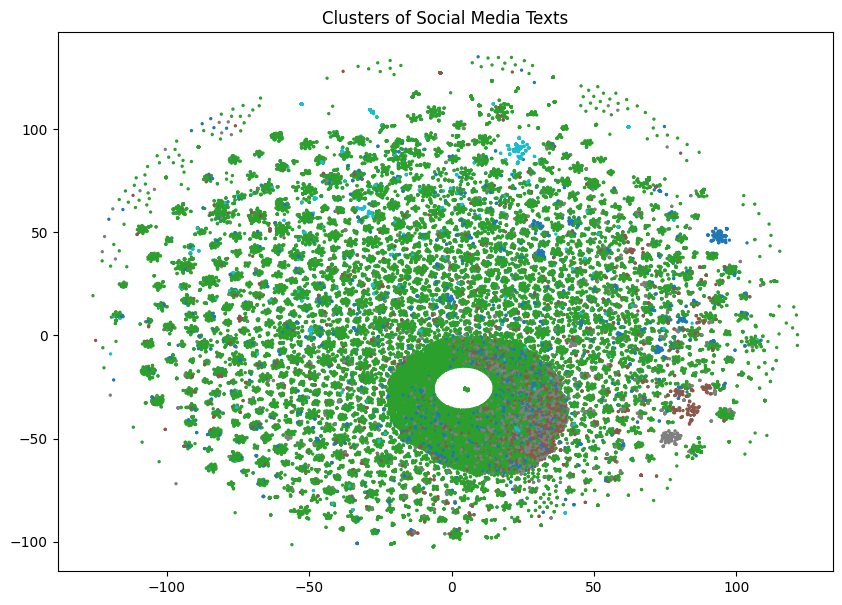

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

plt.figure(figsize=(10,7))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_sample['cluster'], cmap='tab10', s=2)
plt.title("Clusters of Social Media Texts")
plt.show()



In [9]:
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 5
num_sample_texts = 5
num_top_words = 10


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_sample['cluster'] = kmeans.fit_predict(X)


feature_names = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"\n=== Cluster {i} ===")


    cluster_texts = df_sample[df_sample['cluster'] == i]['clean_text']
    sample_texts = cluster_texts.sample(
        n=min(num_sample_texts, len(cluster_texts)),
        random_state=42
    ).tolist()
    for text in sample_texts:
        print("-", text)


    cluster_indices = df_sample[df_sample['cluster'] == i].index
    cluster_vector_sum = X[cluster_indices].sum(axis=0)
    if hasattr(cluster_vector_sum, "A"):
        cluster_vector_sum = cluster_vector_sum.A
    top_word_indices = np.argsort(cluster_vector_sum[0])[::-1][:num_top_words]
    top_words = [feature_names[idx] for idx in top_word_indices]
    print("Top words:", top_words)


    source_counts = df_sample[df_sample['cluster'] == i]['source'].value_counts()
    print("Source distribution:", source_counts.to_dict())



=== Cluster 0 ===
- lol im the same way with the skins
- im telling myself that trump supporters have stopped screeching fake news and begun willfully spreading falsehoods and i guess you think it was fringe voters who took back the house in the midterms
- okay im a celtics fan for this series i went to their subreddit and they accepted my request to be a temporary fan no one beating the celtics but us
- please correct me if im wrong but isnt taking a test while under duress at the teachers order an instant a just doesnt seem fair or ethical at all
- im a caattt im a sneaky lil caatt
Top words: ['im', 'sure', 'just', 'like', 'going', 'sorry', 'gonna', 'youre', 'pretty', 'thats']
Source distribution: {'reddit': 2210, 'instagram': 504}

=== Cluster 1 ===
- can this celtics squad beat golden state
- girls tell me its very important they always say do not have barcode hair
- vegas love it love it
- cant resist
- she assumes that stannis is going to be the champion because of this she misi

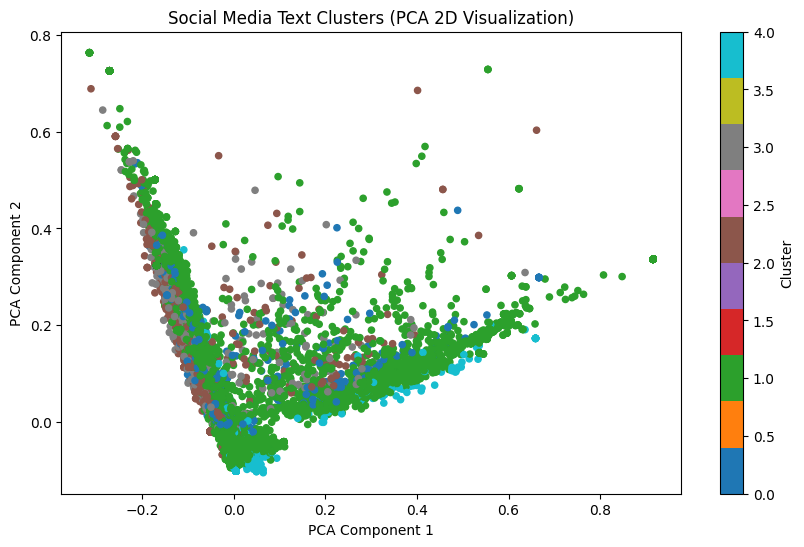

In [10]:
pimport matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce TF-IDF features to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df_sample['cluster'], cmap='tab10', s=20)
plt.title("Social Media Text Clusters (PCA 2D Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()
